In [29]:
from typing import Iterable, Iterator, TypeVar, List, Sequence
from rl.function_approx import Gradient
import rl.markov_process as mp
from rl.markov_decision_process import NonTerminal
import numpy as np
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.approximate_dynamic_programming import extended_vf
from rl.markov_process import (MarkovRewardProcess, NonTerminal,
                               FiniteMarkovRewardProcess, TransitionStep)
from rl.function_approx import AdamGradient
from rl.function_approx import LinearFunctionApprox
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.approximate_dynamic_programming import NTStateDistribution
from typing import Iterable, TypeVar, Callable, Iterator, Sequence

from rl.markov_process import (MarkovRewardProcess, NonTerminal,
                               FiniteMarkovRewardProcess, TransitionStep)
import itertools
import rl.iterate as iterate
from rl.returns import returns
import rl.monte_carlo as mc
from rl.function_approx import learning_rate_schedule
import rl.td as td
import rl.td_lambda as td_lambda
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.approximate_dynamic_programming import NTStateDistribution
import numpy as np
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.chapter2.simple_inventory_mrp import InventoryState
from itertools import islice
from rl.distribution import Choose


S = TypeVar('S')

def mrp_episodes_stream(
    mrp: MarkovRewardProcess[S],
    start_state_distribution: NTStateDistribution[S]
) -> Iterable[Iterable[TransitionStep[S]]]:
    return mrp.reward_traces(start_state_distribution)

def td_lambda_prediction(
        traces: Iterable[Iterable[mp.TransitionStep[S]]],
        approx_0: ValueFunctionApprox[S],
        γ: float,
        lambd: float
) -> Iterator[ValueFunctionApprox[S]]:
    '''Evaluate an MRP using TD(lambda) using the given sequence of traces.
    Each value this function yields represents the approximated value function
    for the MRP after an additional transition within each trace
    Arguments:
      transitions -- a sequence of transitions from an MRP which don't
                     have to be in order or from the same simulation
      approx_0 -- initial approximation of value function
      γ -- discount rate (0 < γ ≤ 1)
      lambd -- lambda parameter (0 <= lambd <= 1)
    '''
    func_approx: ValueFunctionApprox[S] = approx_0
    yield func_approx

    for trace in traces:
        el_tr: Gradient[ValueFunctionApprox[S]] = Gradient(func_approx).zero()
        for step in trace:
            x: NonTerminal[S] = step.state
            y: float = step.reward + γ * \
                extended_vf(func_approx, step.next_state)
            el_tr = el_tr * (γ * lambd) + func_approx.objective_gradient(
                xy_vals_seq=[(x, y)],
                obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1))
            )
            func_approx = func_approx.update_with_gradient(
                el_tr * (func_approx(x) - y)
            )
            yield func_approx

def td_lambda_prediction_learning_rate(
    mrp: MarkovRewardProcess[S],
    start_state_distribution: NTStateDistribution[S],
    gamma: float,
    lambd: float,
    episode_length: int,
    initial_func_approx: ValueFunctionApprox[S]
) -> Iterator[ValueFunctionApprox[S]]:
    episodes: Iterable[Iterable[TransitionStep[S]]] = \
        mrp_episodes_stream(mrp, start_state_distribution)
    curtailed_episodes: Iterable[Iterable[TransitionStep[S]]] = \
        (itertools.islice(episode, episode_length) for episode in episodes)
    return td_lambda.td_lambda_prediction(
        traces=curtailed_episodes,
        approx_0=initial_func_approx,
        γ=gamma,
        lambd=lambd
    )


In [30]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0

gamma: float = 0.9
gamma: float = 0.8  ### I CHOOSE THIS GAMMA FOR FAST CONVERGENCE 
## CLASSICAL SIMPLE INVENTORY
si_mrp = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

all_states = si_mrp.non_terminal_states
true_vf = si_mrp.get_value_function_vec(gamma=gamma)


mc_episode_length_tol: float = 1e-6
num_episodes = 10000

td_episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

#### FUNCTION APPROXIMATION WITH STATE INDICATOR FEATURES  ####
ag = AdamGradient(
    learning_rate=0.05,
    decay1=0.9,
    decay2=0.999
)
ffs=[]
for i in range(capacity+1):
    for j in range(capacity+1-i):
        ffs.append(lambda x: float(x.state.on_hand==i and x.state.on_order==j))

#### we can also use the following features, which is not the tabular case. I just put it here to show an example of it
ffs = [
    lambda _: 1.,
    lambda x: x.state.on_hand,
    lambda x: x.state.on_order
    # lambda x: x[2]
]

ffs: Sequence[Callable[[NonTerminal[InventoryState]], float]] = \
[(lambda x, s=s: float(x.state == s.state)) for s in all_states]
lfa = LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        regularization_coeff=0.0001,
        direct_solve=False
)
lfa = LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        direct_solve=False
)
my_lambda = 0.5
episode_length=1000
it_td_lambda: Iterable[ValueFunctionApprox[InventoryState]] = \
    td_lambda_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(all_states),
        gamma=gamma,
        episode_length=episode_length,
        initial_func_approx=lfa,
        lambd=my_lambda
    )

td_lambda_rmse_vals=[]
td_lambda_episodes: int = 5000
for i, td_lambda_vf in enumerate(islice(it_td_lambda, td_lambda_episodes)):
    td_lambda_rmse: float = np.sqrt(sum(
        (td_lambda_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(all_states)
    ) / len(all_states))
    td_lambda_rmse_vals.append(td_lambda_rmse)
    if i%500==0:
        print(f"TD LAMBDA: Iteration = {i:d}, RMSE = {td_lambda_rmse:.3f}")
print(f"td_lambda_vf {td_lambda_vf.weights.weights}")
print(f"True VF : {true_vf}")

TD LAMBDA: Iteration = 0, RMSE = 15.431
TD LAMBDA: Iteration = 500, RMSE = 7.361
TD LAMBDA: Iteration = 1000, RMSE = 3.985
TD LAMBDA: Iteration = 1500, RMSE = 1.910
TD LAMBDA: Iteration = 2000, RMSE = 0.663
TD LAMBDA: Iteration = 2500, RMSE = 0.606
TD LAMBDA: Iteration = 3000, RMSE = 0.601
TD LAMBDA: Iteration = 3500, RMSE = 0.536
TD LAMBDA: Iteration = 4000, RMSE = 0.523
TD LAMBDA: Iteration = 4500, RMSE = 0.629
td_lambda_vf [-20.49889881 -12.68518955 -13.11628638 -14.26109947 -14.38148901
 -15.17764044]
True VF : [-20.69406782 -13.25880178 -13.36758477 -14.25880178 -14.36758477
 -15.36758477]


In [31]:
##### TABULAR MC CASE  #####
from rl.chapter10.prediction_utils import (
    mc_prediction_learning_rate,
    td_prediction_learning_rate
)
import numpy as np
from itertools import islice

capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0

gamma: float = 0.9
gamma: float = 0.8  ### I CHOOSE THIS GAMMA FOR FAST CONVERGENCE 

## CLASSICAL SIMPLE INVENTORY
si_mrp = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

all_states = si_mrp.non_terminal_states
true_vf = si_mrp.get_value_function_vec(gamma=gamma)


mc_episode_length_tol: float = 1e-6
num_episodes = 10000

td_episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

#### FUNCTION APPROXIMATION WITH STATE INDICATOR FEATURES  ####
ag = AdamGradient(
    learning_rate=0.05,
    decay1=0.9,
    decay2=0.999
)
ffs=[]
for i in range(capacity+1):
    for j in range(capacity+1-i):
        ffs.append(lambda x: float(x.state.on_hand==i and x.state.on_order==j))

ffs: Sequence[Callable[[NonTerminal[InventoryState]], float]] = \
[(lambda x, s=s: float(x.state == s.state)) for s in all_states]
lfa = LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        regularization_coeff=0.0001,
        direct_solve=False
)
lfa = LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        direct_solve=False
)

it_mc: Iterable[ValueFunctionApprox[InventoryState]] = \
    mc_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(all_states),
        gamma=gamma,
        episode_length_tolerance=mc_episode_length_tol,
        initial_func_approx=lfa
    )

mc_rmse_vals=[]
mc_episodes: int = 5000
for i, mc_vf in enumerate(islice(it_mc, mc_episodes)):
    mc_rmse: float = np.sqrt(sum(
        (mc_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(all_states)
    ) / len(all_states))
    mc_rmse_vals.append(mc_rmse)
    if i%500==0:
        print(f"MC: Iteration = {i:d}, RMSE = {mc_rmse:.3f}")
print(f"mc_vf {mc_vf.weights.weights}")
print(f"True VF : {true_vf}")

MC: Iteration = 0, RMSE = 15.431
MC: Iteration = 500, RMSE = 0.595
MC: Iteration = 1000, RMSE = 0.841
MC: Iteration = 1500, RMSE = 0.613
MC: Iteration = 2000, RMSE = 0.399
MC: Iteration = 2500, RMSE = 0.456
MC: Iteration = 3000, RMSE = 0.687
MC: Iteration = 3500, RMSE = 0.250
MC: Iteration = 4000, RMSE = 0.351
MC: Iteration = 4500, RMSE = 0.470
mc_vf [-22.05573253 -15.11769873 -14.97339723 -15.54250007 -15.687255
 -16.20739749]
True VF : [-20.69406782 -13.25880178 -13.36758477 -14.25880178 -14.36758477
 -15.36758477]


In [32]:
capacity: int = 2
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0

gamma: float = 0.9
gamma: float = 0.8  ### I CHOOSE THIS GAMMA FOR FAST CONVERGENCE 

## CLASSICAL SIMPLE INVENTORY
si_mrp = SimpleInventoryMRPFinite(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

all_states = si_mrp.non_terminal_states
true_vf = si_mrp.get_value_function_vec(gamma=gamma)


mc_episode_length_tol: float = 1e-6
num_episodes = 10000

td_episode_length: int = 100
initial_learning_rate: float = 0.03
half_life: float = 1000.0
exponent: float = 0.5

#### FUNCTION APPROXIMATION WITH STATE INDICATOR FEATURES  ####
ag = AdamGradient(
    learning_rate=0.05,
    decay1=0.9,
    decay2=0.999
)
ffs=[]
for i in range(capacity+1):
    for j in range(capacity+1-i):
        ffs.append(lambda x: float(x.state.on_hand==i and x.state.on_order==j))

ffs: Sequence[Callable[[NonTerminal[InventoryState]], float]] = \
[(lambda x, s=s: float(x.state == s.state)) for s in all_states]
lfa = LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        regularization_coeff=0.0001,
        direct_solve=False
)
lfa = LinearFunctionApprox.create(
        feature_functions=ffs,
        adam_gradient=ag,
        direct_solve=False
)


it_td: Iterable[ValueFunctionApprox[InventoryState]] = \
    td_prediction_learning_rate(
        mrp=si_mrp,
        start_state_distribution=Choose(all_states),
        gamma=gamma,
        episode_length=td_episode_length,
        initial_func_approx=lfa
    )

td_rmse_vals=[]
td_experiences: int = 5000
for i, td_vf in enumerate(islice(it_td, td_experiences)):
    td_rmse: float = np.sqrt(sum(
        (td_vf(s) - true_vf[i]) ** 2 for i, s in enumerate(all_states)
    ) / len(all_states))
    td_rmse_vals.append(td_rmse)
    if i%25000==0:
        print(f"TD: Iteration = {i:d}, RMSE = {td_rmse:.3f}")

print(f"td_vf {td_vf.weights.weights}")
print(f"True VF : {true_vf}")


TD: Iteration = 0, RMSE = 15.431
td_vf [-20.4631189  -13.93313007 -13.17367169 -14.43305095 -14.21275456
 -15.57657842]
True VF : [-20.69406782 -13.25880178 -13.36758477 -14.25880178 -14.36758477
 -15.36758477]


In [33]:
from rl.distribution import Categorical
user_capacity = 2
user_poisson_lambda = 1
user_holding_cost = 1
user_stockout_cost = 10

user_gamma = 0.8

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

from rl.markov_process import FiniteMarkovProcess
print("Transition Map")
print("--------------")
print(FiniteMarkovProcess(
    {s.state: Categorical({s1.state: p for s1, p in v.table().items()})
        for s, v in si_mrp.transition_map.items()}
))

print("Transition Reward Map")
print("---------------------")
print(si_mrp)

print("Stationary Distribution")
print("-----------------------")
si_mrp.display_stationary_distribution()
print()

print("Reward Function")
print("---------------")
si_mrp.display_reward_function()
print()

print("Value Function")
print("--------------")
si_mrp.display_value_function(gamma=user_gamma)
print()

Transition Map
--------------
From State InventoryState(on_hand=0, on_order=0):
  To State InventoryState(on_hand=0, on_order=2) with Probability 1.000
From State InventoryState(on_hand=0, on_order=1):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=0, on_order=2):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=0) with Probability 0.264
From State InventoryState(on_hand=1, on_order=0):
  To State InventoryState(on_hand=1, on_order=1) with Probability 0.368
  To State InventoryState(on_hand=0, on_order=1) with Probability 0.632
From State InventoryState(on_hand=1, on_order=1):
  To State InventoryState(on_hand=2, on_order=0) with Probability 0.368
  To State InventoryState(on_hand=1, on_order=0) with Probability 0.368


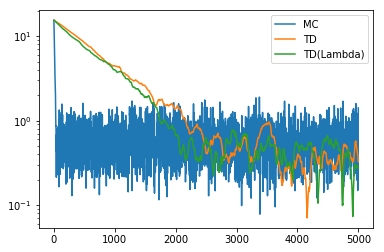

In [35]:
 ##### CONVERGENCE RATE  #####
import matplotlib.pyplot as plt
plt.figure()
plt.plot(mc_rmse_vals)
plt.plot(td_rmse_vals)
plt.plot(td_lambda_rmse_vals)
plt.yscale("log")
plt.legend(["MC","TD",f"TD(Lambda={my_lambda})"])